In [2]:
!pip install git+https://github.com/huggingface/transformers.git sentencepiece



  Cloning https://github.com/huggingface/transformers.git to c:\users\harsh\appdata\local\temp\pip-req-build-tjnbi74i
  Resolved https://github.com/huggingface/transformers.git to commit bdb9106f247fca48a71eb384be25dbbd29b065a8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git 'C:\Users\harsh\AppData\Local\Temp\pip-req-build-tjnbi74i'


Note that you don't need to specify the source language, it will be automatically understood by the model!

In [1]:
from transformers import AutoProcessor,SeamlessM4Tv2ForSpeechToText
import torchaudio
import torch

processor = AutoProcessor.from_pretrained("facebook/seamless-m4t-v2-large")
model = SeamlessM4Tv2ForSpeechToText .from_pretrained("facebook/seamless-m4t-v2-large")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# device="cpu"
model = model.to(device)


C:\Users\harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\harsh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00, 

In [22]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [8]:
import librosa


audio_file_path = "demo_audio_text/trimmed_10s.mp3"
audio_data, sampling_rate = librosa.load(audio_file_path, sr=None)  # sr=None to preserve the original sampling rate

print(f"Sampling rate: {sampling_rate}")



Sampling rate: 22050


##### The sampling rate is higher, therefore we need to resample it such that the sample rate is 16000
##### Source - https://colab.research.google.com/github/ylacombe/scripts_and_notebooks/blob/main/v2_seamless_m4t_hugging_face.ipynb#scrollTo=4g752C4akT0Z



In [9]:
import torchaudio
import torch


# Load the audio file
audio_waveform, orig_sampling_rate = torchaudio.load(audio_file_path)

# Define the target sampling rate
target_sampling_rate = 16000

# Resample the audio if the original sampling rate is different from the target
if orig_sampling_rate != target_sampling_rate:
    audio_waveform = torchaudio.functional.resample(
        audio_waveform, 
        orig_freq=orig_sampling_rate, 
        new_freq=target_sampling_rate
    )

print(f"Original sampling rate: {orig_sampling_rate}")
print(f"Resampled rate: {target_sampling_rate}")
print(f"Audio waveform shape: {audio_waveform.shape}")


# Convert the audio waveform to a numpy array (if needed)
audio_array = audio_waveform.numpy()

# Now, use the processor
# Assuming `processor` is already defined and configured for your model
audio_inputs = processor(audios=audio_array, sampling_rate=target_sampling_rate, return_tensors="pt").to(device)


Original sampling rate: 22050
Resampled rate: 16000
Audio waveform shape: torch.Size([2, 187698])


In [11]:
import os
def save_transcription(transcribed_text, output_folder):
    output_file_path = os.path.join(output_folder, "transcription.txt")
    with open(output_file_path, "w", encoding="utf-8") as file:
        file.write(transcribed_text)

output_tokens = model.generate(**audio_inputs, tgt_lang="mar")
transcribed_text = processor.decode(output_tokens[0].tolist()[0], skip_special_tokens=True)
demo_folder="demo_audio_text"
save_transcription(transcribed_text, demo_folder)
print(f"Transcription from Marathi audio: {transcribed_text}")

Transcription from Marathi audio: 


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import nltk


nltk.download("punkt")

def tokenize_text(text):
    return nltk.word_tokenize(text)

def calculate_wer(reference_text, hypothesis_text):
    # Tokenize both reference and hypothesis texts
    reference_tokens = tokenize_text(reference_text)
    hypothesis_tokens = tokenize_text(hypothesis_text)
    distance = nltk.edit_distance(reference_tokens, hypothesis_tokens)

    # Compute WER
    wer = distance / len(reference_tokens)
    return wer


demo_folder = "demo_audio_text"
reference_file_path = os.path.join(demo_folder, "matthew_1.txt")
translated_text = os.path.join(demo_folder,"transcription.txt")  # Translated Marathi text

wer = calculate_wer(reference_text, translated_text)
print("Word Error Rate (WER): {:.2f}%".format(wer * 100))


[Text(0.5, 1.0, 'Auto-correlation'),
 Text(0.5, 0, 'Lag (frames)'),
 Text(0, 0.5, 'Correlation')]

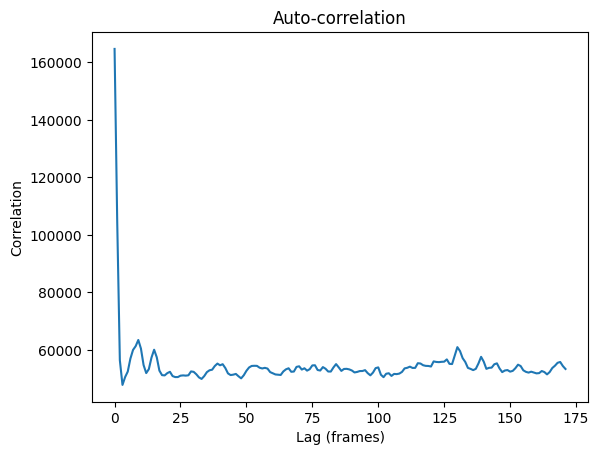

In [12]:
## Audio Analysis
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile
import pandas as pd

y, sr = librosa.load('demo_audio_text/matthew_1.mp3')
onset_strength = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512)
correlation = librosa.autocorrelate(onset_strength, max_size=4 * sr // 512)
fig, ax = plt.subplots()
ax.plot(correlation)
ax.set(title='Auto-correlation', xlabel='Lag (frames)', ylabel = 'Correlation')

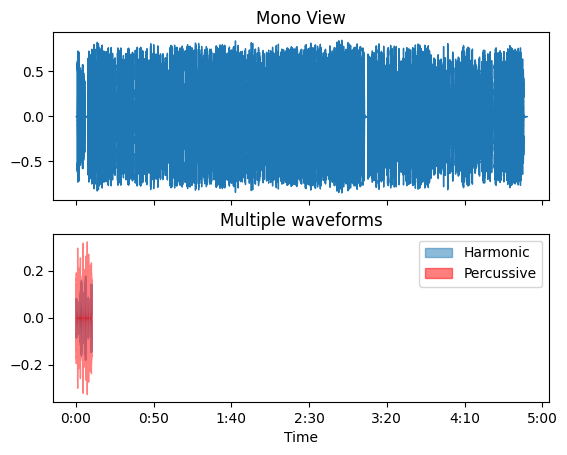

In [13]:
import librosa.display
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title='Mono View')
ax[0].label_outer()

y, sr = librosa.load(librosa.ex('choice'), duration=10)
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[1], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r',
                         alpha=0.5, ax=ax[1], label='Percussive')
ax[1].set(title='Multiple waveforms')
ax[1].legend()

In [15]:
def extract_feature(file_name):
    with soundfile.SoundFile(file_name) as sound_file:
        file = sound_file.read(dtype="float32")
        result = np.array([])
        sample_rate = sound_file.samplerate
        # Calculate MFCC
        mel_frequency = np.mean(librosa.feature.mfcc(y=file, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mel_frequency))
        # Calculate Chroma
        chroma = np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(file)), sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
        # Calculate Spectral Scale
        spectralScale = np.mean(librosa.feature.melspectrogram(file, sr=sample_rate).T, axis=0)
        result = np.hstack((result, spectralScale))
    return result


result=extract_feature("demo_audio_text/trimmed_10s.mp3")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)